### Jade's Changes

<b>Current problems</b>:
- amp;
- div &gt; div.group &gt; p:first-child"&gt; = video cnbc
- no space between words separated by new line
- Check out the companies making headlines before the belldiv gt divgroup gt pfirstchildgt
- CNBC in general
- shit at the end: To contact... blah blah
- © CNBC is a USA TODAY content partner offering financial news and commentary. Its content is produced independently of USA TODAY.
- Read or Share this story:
- Read more here.
- FT subscribers can click here to receive Market Forces every day by email.
- Your feedback
- I'd love to hear from you. You can email me on michael.mackenzie@ft.com and follow me on Twitter at @michaellachlan.
- COPYRIGHT
- © 2019 Bloomberg L.P
- (Bloomberg)—
- Anything with "Transcript" should be removed
- Write to Sara Castellanos at sara.castellanos@wsj.com
- Disclosure: Cramer's charitable trust owns shares of Johnson &amp; Johnson.
- Questions for Cramer?Call Cramer: 1-800-743-CNBC
- Want to take a deep dive into Cramer's world? Hit him up!Mad Money Twitter - Jim Cramer Twitter - Facebook - Instagram
- Questions, comments, suggestions for the "Mad Money" website? madcap@cnbc.com
- RPT-

<b>Some rules I'm considering</b>:
- Rid articles with less than 5 periods
- Rid articles where writers say "I" a lot
- ~~Rid anything with Jim Cramer~~ done
- ~~Rid articles with title containing "transcript"~~ done
- ~~Rid articles with title containing "rpt" (repeat)~~ done

Within articles:
- Periods between 2 numbers should be preserved
- Remove any lines in articles that don't contain periods
- Remove any lines that don't have more than 5 words
- Remove sentences containing "more here"
- Remove anything after ©
- Remove any of the last 3 sentences if they contain "questions, comments" or "email" or "write to" or "I"

In [1]:
# imports
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import pandas as pd
import re, string

In [2]:
# Import articles
def importData(filename):
    """
    Import data into df
    """
    #Import Labelled Data
    DATA_DIR = "Data"
    thispath = Path().absolute()
    ARTICLES = os.path.join(DATA_DIR, filename)
    
    df = pd.read_excel(ARTICLES)

    try:
        df.head()
    except:
        pass
    return df

In [3]:
import matplotlib.pyplot as plt
def initialize_plot():
    plt.plot()
    plt.ylabel('Number of words')
    plt.xlabel('')
    plt.title("Number of words in articles pre-clean (n=%s)"%(len(df)))
    return plt

In [4]:
df = importData("Labelled_Articles_Raw _Merged.xlsx")

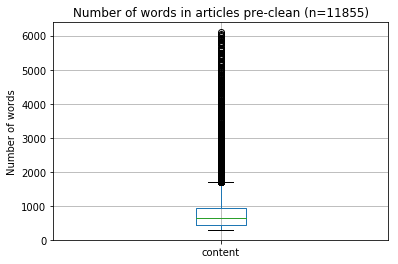

In [5]:
df['badly_cleaned_content'] = df['content']
df['content'] = df['originalcontent']
df = df[df['content'].str.split().str.len() > 300]
bp = initialize_plot()
bp = df['content'].str.split().str.len().to_frame().boxplot()
plt.show()

In [6]:
#remove blanks (NaN)
df = df.dropna(subset = ['content', 'title']) 

#remove blocked articles without content
df = df[df.content.str.contains('Your usage has been flagged', case=False) == False]
df = df[df.content.str.contains('To continue, please click the box', case=False) == False]

#remove vidoes/ads/commentary
df = df[df.description.str.contains('The "Fast Money" traders share their first moves for the market open.', case=False) == False]
df = df[df.description.str.contains('stuff we think you', case=False) == False]

#remove transcripts
df = df[df.title.str.contains('transcript', case=False) == False]

#remove cramer
df = df[df.title.str.contains('cramer', case=False) == False]

#keep articles with more than 300 words, which is the lower end of the boxplot
#df = df[df['content'].str.split().str.len() > 300]

#remove duplicates
# by self-identified repeat
df = df[df.title.str.contains('rpt', case=False) == False]
# by title
df = df.drop_duplicates(subset=['title'], keep='first')
# by content
df = df.drop_duplicates(subset=['content'], keep='first')
# by decription
df = df.drop_duplicates(subset=['description'], keep='first')

df = df.reset_index(drop=True)


# CLEAN ORIGINAL CONTENT
df['origContent'] = df['content'] 

print(df['origContent'].iloc[4])

#Remove nonsense sentences from original content pull
for i in df.index:
    
    article = df['origContent'].iloc[i].split('\r\n')
   
    # remove lines with no period
    article[:] = [sentence for sentence in article if '.' in sentence]
    # remove lines with less than 5 words
    article[:] = [sentence for sentence in article if len(sentence.split())>5]
    # remove photo credits
    article[:] = [sentence for sentence in article if not('Photo' in sentence)]
    blackList = ['get breaking news','click here','write to','subscribe','read more','read or share','reporting by','twitter, instagram','comment','copyright','©', 'please read' ,'blog', 'editor', 'opinion section']
    # remove lines with terms that are associated with useless sentences
    article[:] = [sentence for sentence in article if not any(term in sentence.lower() for term in blackList)]

    df.at[i,'origContent']='\r\n'.join(article)

#Remove videos from cnbc links
pat_cnbcVid = re.compile('div &gt; div\.group &gt; p:first-child"&gt;')
df['origContent'] = list(map(lambda x: pat_cnbcVid.sub('', x), df['origContent']))
#Remove amp;
pat_amp = re.compile('amp;')
df['origContent'] = list(map(lambda x: pat_amp.sub('', x), df['origContent']))

# CLEAN CONTENT FOR FEATURE SELECTION df['content'] AND CONTEXT EXTRACTION df['contentWithStops'] 


#Remove time
#pat_time = re.compile('[0-9]{0,2}:?[0-9]{1,2}\s?[aApP]\.?[mM]\.?')
#df['content'] = list(map(lambda x: pat_time.sub(' ', x), df['origContent'].str.lower()))



#Remove urls
pat_url = re.compile('[a-z]+?[.]?[a-z]+?[.]?[a-z]+[.]?[\/\/]\S+')
df['content'] = list(map(lambda x: pat_url.sub('URL', x), df['content']))
pat_https = re.compile('https://')
df['content'] = list(map(lambda x: pat_https.sub('', x), df['content']))

print(df['content'].iloc[4])

#Remove stopwords
stopwords = [
    # dates/times
    "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "jan", "feb","mar", "apr", "jun", "jul", "aug", "oct", "nov", "dec", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "morning", "evening","today","pm","am",
    # specific article terms that are useless
    "read", "share", "file", "'s", "photo", "inc", "corp", "group", "inc", "corp", "source", "bloomberg", "cnbc","cnbcs", "cnn", "reuters","bbc", "published", "broadcast","york","msnbc","ap","said",
    # other useless terms
    "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "co", "inc", "com", "theyve", "theyre", "theres", "heres", "didnt", "wouldn", "couldn", "didn","nbcuniversal","according", "just", "us", "ll", "times","yes","such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "just", "don", "now", "will", "wasn", "etc", "but", "hello", "welcome", "re","my",     
    # etc
    "also","us","the", "a", "of", "have", "has", "had", "having", "hello", "welcome", "yeah", "wasn", "today", "etc", "ext","definitely", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "while", "of", "at", "by", "for", "about", "into", "through", "during", "before", "after", "to", "from", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "just", "don", "now", "will"
]

pat_stopwords = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
df['content'] = list(map(lambda x: pat_stopwords.sub(' ', x), df['content'].str.lower()))


#Remove single character words
pat_charLim = re.compile('\s[a-zA-Z]\s')
df['content'] = list(map(lambda x: pat_charLim.sub(' ', x), df['content']))

#Remove characters that don't separate a sentence or aren't $ signs
# FOR context extraction
pat_nonStops = re.compile('[^\.\?!,;\$0-9a-zA-Z]+')
df['contentWithStops'] = list(map(lambda x: pat_nonStops.sub(' ', x), df['content']))

#Remove punctuation 
# FOR feature selection/encoding
pat_punctuation = re.compile('[^a-zA-Z]+')
df['content'] = list(map(lambda x: pat_punctuation.sub(' ', x), df['content']))

#Remove single characters
df['content'] = list(map(lambda x: pat_charLim.sub(' ', x), df['content']))

Barnes' daughter, Jenise Raven, worked for weeks to get Bezos' attention ahead of her mother's 80th birthday, according to a report from local Houston news station KHOU 11. Raven was hoping Bezos might send a card. Instead, Bezos said happy birthday via the video embedded above. Raven played the video at her mother's party on Saturday. KHOU 11 published a piece about the video Monday and Amazon provided the video to CNBC Make It. In the video, Bezos says: "Hi Mrs. Barnes, it's Jeff Bezos. You were one of my favorite teachers back in elementary school. I remember you from 4th grade very well. You may not recognize me, I had more hair back then, but I sure remember you. You had a big impact on me. I heard you were turning 80. That's a big milestone! Congratulations and happy birthday. I learned a lot at River Oaks. You were definitely one of my favorite teachers. Thank you for making 4th grade so special for me and for all the other kids too. I know you've been more than 30 years as a te

In [7]:
df.index

RangeIndex(start=0, stop=10753, step=1)

In [8]:
df['origContent'].iloc[4]

'Barnes\' daughter, Jenise Raven, worked for weeks to get Bezos\' attention ahead of her mother\'s 80th birthday, according to a report from local Houston news station KHOU 11. Raven was hoping Bezos might send a card. Instead, Bezos said happy birthday via the video embedded above. Raven played the video at her mother\'s party on Saturday. KHOU 11 published a piece about the video Monday and Amazon provided the video to CNBC Make It. In the video, Bezos says: "Hi Mrs. Barnes, it\'s Jeff Bezos. You were one of my favorite teachers back in elementary school. I remember you from 4th grade very well. You may not recognize me, I had more hair back then, but I sure remember you. You had a big impact on me. I heard you were turning 80. That\'s a big milestone! Congratulations and happy birthday. I learned a lot at River Oaks. You were definitely one of my favorite teachers. Thank you for making 4th grade so special for me and for all the other kids too. I know you\'ve been more than 30 years

In [9]:
df['content'].iloc[4]

'barnes daughter jenise raven worked weeks get bezos attention ahead mother th birthday report local houston news station khou raven hoping bezos might send card instead bezos happy birthday via video embedded above raven played video mother party khou piece video amazon provided video make video bezos says hi mrs barnes jeff bezos one favorite teachers back elementary school remember th grade well recognize hair back sure remember big impact heard turning big milestone congratulations happy birthday learned lot river oaks one favorite teachers thank making th grade special kids know ve years teacher principal ve big impact people lives great teachers change lives incredibly lucky happy birthday mrs barnes need mom know special people touched throughout journey says raven speaking khou news m appreciative grateful humbled whole experience barnes surprised happy thrilled see lot students different roles former students jeff one really outstanding m pleased see says barnes khou fabulous 

In [10]:
df['contentWithStops'].iloc[4]

'barnes daughter, jenise raven, worked weeks get bezos attention ahead mother 80th birthday, report local houston news station khou 11. raven hoping bezos might send card. instead, bezos happy birthday via video embedded above. raven played video mother party . khou 11 piece video amazon provided video make . video, bezos says hi mrs. barnes, jeff bezos. one favorite teachers back elementary school. remember 4th grade well. recognize , hair back , sure remember . big impact . heard turning 80. big milestone! congratulations happy birthday. learned lot river oaks. one favorite teachers. thank making 4th grade special kids . know ve 30 years teacher principal. ve big impact people lives. great teachers change lives. incredibly lucky . happy birthday, mrs. barnes! i need mom know special, , people touched throughout journey, says raven, speaking khou 11 news. i m appreciative grateful humbled whole experience. barnes surprised happy. i thrilled. see lot students different roles, former st

In [11]:
import matplotlib.pyplot as plt
def initialize_plot():
    plt.plot()
    plt.ylabel('Number of words')
    plt.xlabel('')
    plt.title("Number of words in each articles (n=%s)"%(len(df)))
    return plt

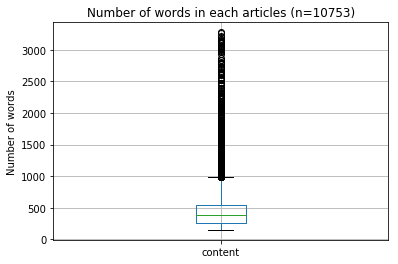

In [12]:
#df = df[df['content'].str.split().str.len() > 500]
bp = initialize_plot()
bp = df['content'].str.split().str.len().to_frame().boxplot()
plt.show()

In [13]:
df['content'].str.split().str.len().iloc[100]

643

In [14]:
OUTPUT_DIR = os.path.join("Data", 'Labelled_Articles_cleaned.xlsx')
writer = pd.ExcelWriter(OUTPUT_DIR)
df.to_excel(writer,'Sheet1')
writer.save()

In [59]:
test = ["I I I I I", "I. I. I. I.", "I. I . I .I .I .I", "I . a dad , I s.djaf I. I. i","I . a dad , I sdjaf I I i"]


In [60]:
for line in test:
    print(i,line.split().count('I'))

0 5
0 0
0 2
0 2
0 4
